# LC3 DATA ANALYSIS

In this notebook we analize the relation of the compressive strength of LC3 with the clay used for its elaboration properties. For this purpose we utilize the dataset given by the Constructions Materials Laboratory at EPFL. This dataset consists of different measures of compressive strength for different types of LC3 cement in which the clay used for their ellaboration varies. We have also several clay properties measured and the objetive is finding the relation of the compressive strength (CS) with these for a deeper understanding of key elements in LC3 cement.

### Load libraries and data

In [1]:
from lc3_implementations import *

In [2]:
# Input file path (can be also an excel .xlsx)
DATA_PATH = './data/data_merged.ods'

In [3]:
# Read data skipping the first row and considering also '-' as NaN
data = pd.read_excel(DATA_PATH, skiprows=[0], na_values=['-'])
# We rename some columns for having an easier reference
rename_cols(data)
# Sorting allows us to plot functions more easily
data = data.sort_values('Kaolinite_content')

In [4]:
# Uncomment for seeing data loaded
#data               # Get data
#data.describe()    # Get data general information
#data.columns       # Get data features names
#data.corr()        # Get correlation matrix

### Visualize data

In [5]:
# Take kaolinite content
x = data['Kaolinite_content'].values 

# Take compression strengths
y1  = data[ "day_1"].values
y3  = data[ "day_3"].values
y7  = data[ "day_7"].values
y28 = data["day_28"].values
y90 = data["day_90"].values

# Measures at 90 days have missing values (4 in total)
x90 =   x[np.logical_not(np.isnan(y90))]
y90 = y90[np.logical_not(np.isnan(y90))]

# Take standard deviations
#z1  = data[ "STD_1D"].values
#z3  = data[ "STD_3D"].values
#z7  = data[ "STD_7D"].values
#z28 = data["STD_28D"].values
#z90 = data["STD_90D"].values

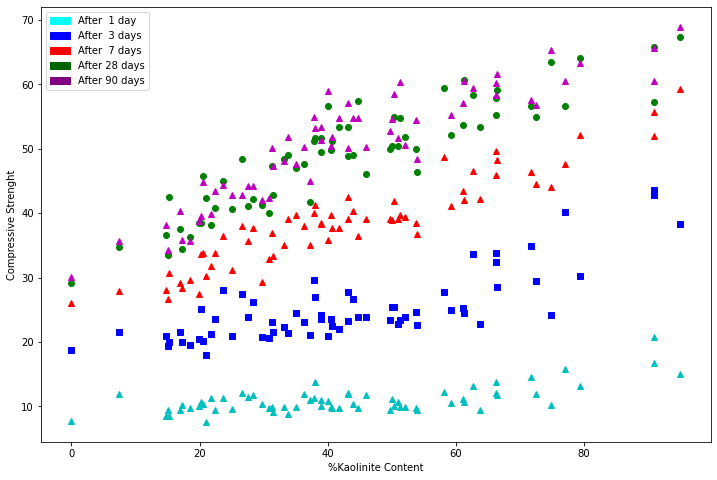

In [6]:
visualize_data(x,y1,x,y3,x,y7,x,y28,x90,y90)

**First sight analysis:**

* **CS Day 1:** Almost constant, it curves from kaolinite content 50%, try degree two feature expansion.
* **CS Day 3:** Sparse points, we need to add another feature and maybe try also feature expansion.
* **CS Day 7:** The straight line is quite clear, we can try adding another feature for avoiding sparsification.
* **CS Day 28:** Straight line until 40% kaolinite content, then it curves. Feature expansion is needed as well as another feature for reducing sparsification.
* **CS Day 90:** Totally analogous to the day 28 data.


**Observations and next steps:**
* Maybe it would be interesting to have a predictor of the compression strength at 90 days (at time=infinity) knowing the compression strength before.
* In feature augmentation never go further than degree two, the curve is clearly always increasing.
* When having models involving only one or two features it's going to be important to plot for checking correctness.
* We have to also search mathematical measurements for the correctness of our models.

### Data correlation analysis

We have measures of 21 features/properties of the clays. Which are the (cor)relations among them? Which are the most important for predicting the compression strength? Are there redundancies?  We first try to answer this question by analyzing the correlations.

In [7]:
# Function to hightlight high correlated cells in red
def highlight_high_correlations(cell):
    return 'background-color: %s' % ('red' if (cell != 1 and abs(cell) > CORRELATION_THRESHOLD) else 'white')

In [8]:
# Correlation between clays properties themselves
CORRELATION_THRESHOLD = 0.6

corr_matrix = data.corr()[10:].iloc[:, 10:]
corr_matrix.style.applymap(highlight_high_correlations)

,Kaolinite_content,Dv50,D10,D90,span,BET_specific_surface,SiO2,Al2O3,Fe2O3,CaO,MgO,SO3,Na2O,K2O,TiO2,P2O5,MnO,Others,LOI
Kaolinite_content,1.000000,-0.193017,-0.305015,-0.244189,0.084664,0.089423,-0.660779,0.916209,-0.254266,-0.202572,-0.338773,0.016628,-0.200614,-0.411239,0.414770,-0.035480,0.316228,0.024821,0.231897
Dv50,-0.193017,1.000000,0.451829,0.776255,0.119163,-0.015583,0.287292,-0.242921,-0.189271,0.042118,0.052258,0.077456,-0.096222,0.074709,-0.006009,0.385650,0.255514,-0.084343,-0.230361
D10,-0.305015,0.451829,1.000000,-0.035547,-0.436280,-0.404479,0.382222,-0.145179,-0.431953,-0.214363,-0.187739,0.225985,0.012912,0.618675,-0.589368,0.378885,-0.771972,-0.200548,-0.064193
D90,-0.244189,0.776255,-0.035547,1.000000,0.736569,-0.089815,0.193764,-0.340139,-0.028480,0.342000,0.365395,0.975371,-0.132507,0.047146,-0.043585,0.138796,-0.142464,-0.011756,-0.171109
span,0.084664,0.119163,-0.436280,0.736569,1.000000,0.101806,-0.072553,-0.042011,0.082441,0.072997,-0.075898,0.033117,-0.094787,-0.161342,0.197525,-0.029135,0.115944,-0.168370,-0.043502
BET_specific_surface,0.089423,-0.015583,-0.404479,-0.089815,0.101806,1.000000,-0.421059,0.052440,0.619421,-0.100527,0.147891,-0.151082,-0.016290,-0.183056,0.099011,-0.142684,0.643980,-0.342051,0.152745
SiO2,-0.660779,0.287292,0.382222,0.193764,-0.072553,-0.421059,1.000000,-0.725183,-0.364198,-0.108063,-0.181542,-0.208559,-0.144506,0.130411,-0.410854,-0.038594,-0.305488,0.057821,-0.390461
Al2O3,0.916209,-0.242921,-0.145179,-0.340139,-0.042011,0.052440,-0.725183,1.000000,-0.282481,-0.211962,-0.286575,-0.169586,-0.213801,-0.315134,0.369314,-0.051612,0.372933,-0.036482,0.308423
Fe2O3,-0.254266,-0.189271,-0.431953,-0.028480,0.082441,0.619421,-0.364198,-0.282481,1.000000,0.004174,0.231275,0.008352,0.158245,-0.114540,0.208177,0.095215,0.104339,-0.108749,-0.060084
CaO,-0.202572,0.042118,-0.214363,0.342000,0.072997,-0.100527,-0.108063,-0.211962,0.004174,1.000000,0.569413,0.625109,0.496111,-0.086462,-0.304487,-0.135553,-0.081563,0.128110,0.067826


In [9]:
# Correlation between Compression Strength measurements and clays properties
CORRELATION_THRESHOLD = 0.65

corr_matrix = data.corr()[10:].iloc[:, [0,2,4,6,8]]
corr_matrix.style.applymap(highlight_high_correlations)

,day_1,day_3,day_7,day_28,day_90
Kaolinite_content,0.658071,0.781898,0.930966,0.900876,0.911653
Dv50,-0.111246,-0.011320,-0.116061,-0.146193,-0.152193
D10,-0.274278,-0.351558,-0.296297,-0.287737,-0.290692
D90,-0.225330,-0.169381,-0.147715,-0.131897,-0.141472
span,-0.008618,0.096408,0.176071,0.178734,0.099044
BET_specific_surface,-0.077832,-0.032558,0.083831,0.108786,0.198791
SiO2,-0.430950,-0.443933,-0.563664,-0.579837,-0.635442
Al2O3,0.614406,0.705345,0.834569,0.809226,0.845753
Fe2O3,-0.268702,-0.284461,-0.265054,-0.259344,-0.242389
CaO,-0.171936,-0.143753,-0.217687,-0.181013,-0.136114


In [10]:
# Correlation between standard deviations of measurements and clays properties
CORRELATION_THRESHOLD = 0.2

corr_matrix = data.corr()[10:].iloc[:, [1,3,5,7,9]]
corr_matrix.style.applymap(highlight_high_correlations)

,STD_1D,STD_3D,STD_7D,STD_28D,STD_90D
Kaolinite_content,0.098020,0.462649,0.183329,0.358627,0.191225
Dv50,-0.118125,-0.129720,-0.113932,-0.185816,-0.105022
D10,-0.159055,-0.401368,-0.215840,-0.224444,-0.245231
D90,-0.018398,-0.070994,-0.032689,-0.082954,0.184129
span,0.020704,0.055594,0.044010,0.022846,0.143911
BET_specific_surface,-0.345532,0.010624,-0.092784,0.131376,-0.059141
SiO2,0.006149,-0.302855,-0.086754,-0.322744,-0.080277
Al2O3,0.029920,0.394946,0.248389,0.322680,0.106657
Fe2O3,-0.137893,-0.100728,-0.108874,0.004947,0.019647
CaO,0.140246,0.012872,-0.146547,-0.101726,0.134408


**First sight analysis:**

* Several important correlations between features, be aware of this when choosing features for our model to avoid redundancy.
* Compression strength can be predicted quite well with only the Kaolinite content, the relation is clear.
* At first sight there is no clear evidence of any feature being behind the standard deviation/variability of lc3.

# COMPRESSION STRENGTH (CS)

### Linear regression models

We have seen that the kaolinite content is the most predictive feature that we have. We are going to start creating simple linear regression models and then, following the appreciations obtained by visualizing the data, we are going to create non-linear models based on the kaolinite content for better fitting the data distribution as well as models with more features for avoiding data sparsification.

Two metrics are going to be extremely important here:
* **R square:** Is giving us a measurement of how good is our model (the closer to 1.0 the better). 
* **Validation score:** Is going to let us control overfitting. Improving R² means nothing if validation is worse. We'll use mean squared error with Leave One Out cross validation to estimate it.

#### Linear models based on the kaolinite content

f(x) = 8.182078798084477 + 0.06610392732898104*x


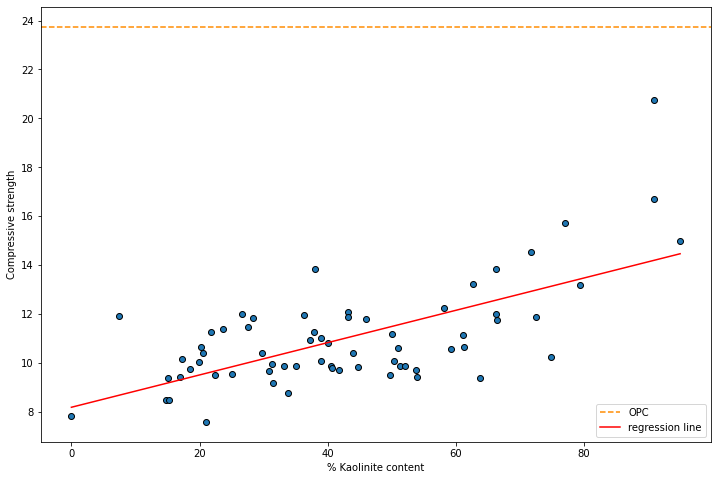

MSE: 2.831728556226933
R^2: 0.4330574737902103


In [11]:
leave_one_out_validation(x.reshape(-1,1), y1,1)

f(x) = 16.544774345389964 + 0.20197895450867684*x


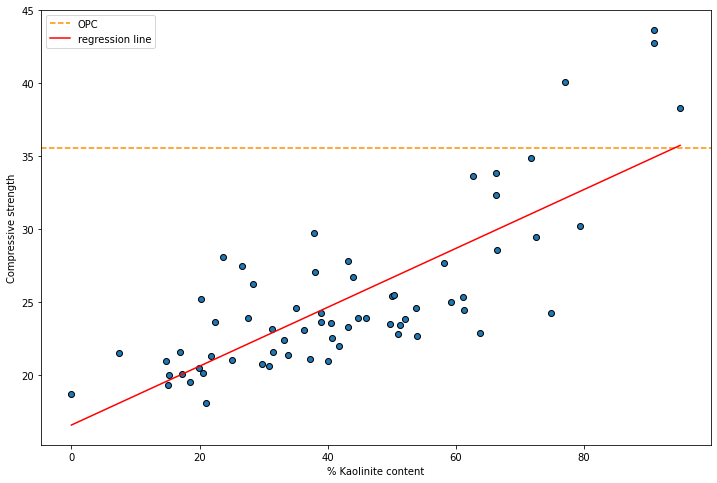

MSE: 12.675898171489052
R^2: 0.6113650603318864


In [12]:
leave_one_out_validation(x.reshape(-1,1), y3,3)

f(x) = 25.30760246706364 + 0.30925338626977783*x


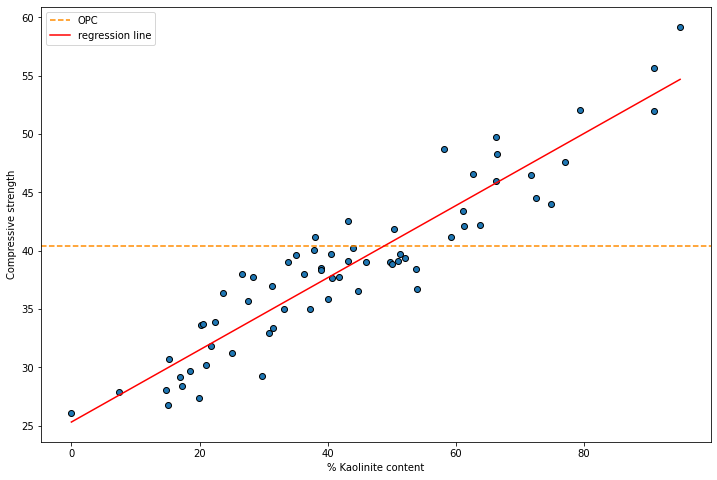

MSE: 7.00392455294012
R^2: 0.8666969837714468


In [13]:
leave_one_out_validation(x.reshape(-1,1), y7, 7)

f(x) = 33.62781210162508 + 0.3558471318971575*x


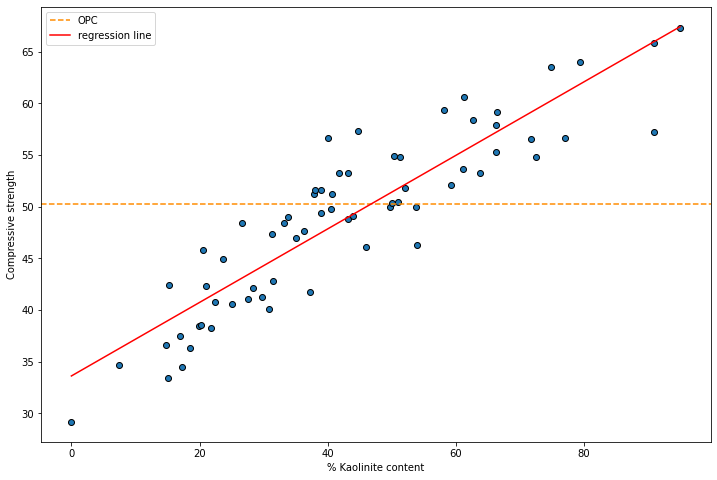

MSE: 14.031208977513867
R^2: 0.8115769970840359


In [14]:
leave_one_out_validation(x.reshape(-1,1), y28, 28)

f(x) = 34.473502265715304 + 0.3745752546931824*x


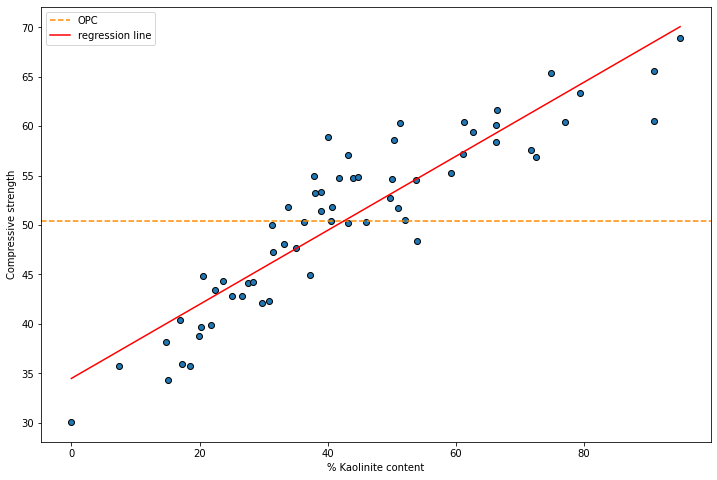

MSE: 13.593520931397066
R^2: 0.8311103650575946


In [15]:
leave_one_out_validation(x90.reshape(-1,1), y90, 90)

**First sight analysis:**

* There is few more we can improve at the 7th day using only the kaolinite content, data distribution is quite linear.
* For 1st and 3rd day the problem is more the sparsification of the points than the lack of expresivity of the model.
* For 28th and 90th day until 40% of kaolinite content the compression strength increases linearly and then estabilizes. Makes sense a non-linear model.
* It doesn't make sense in any model a degree 3 regression model, compression strength increases with kaolinite content.

#### Non-linear models based on the kaolinite content

In [16]:
# x_2 = Kaolinite content, (Kaolinite content)^2
x_2   = np.array([x, x**2]).T
x90_2 = np.array([x90,x90*x90]).T 

f(x) = 10.484771154982106 + -0.05561573487176187*x + 0.0012762473993578132*x^2


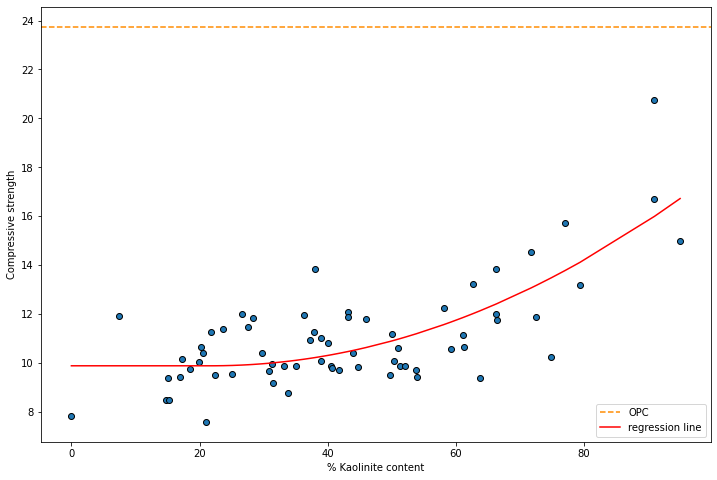

MSE: 2.5126547736924403
R^2: 0.5395335354132512


In [17]:
leave_one_out_validation(x_2, y1, 1)

f(x) = 21.868297363985256 + -0.07942095616558513*x + 0.0029505167668412717*x^2


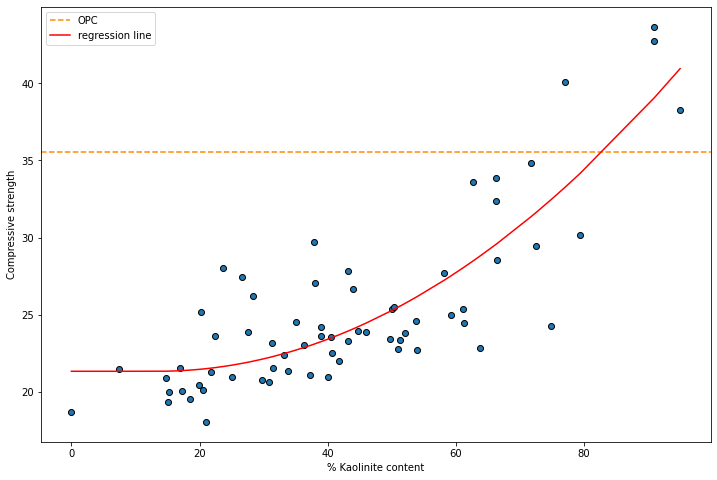

MSE: 10.154742232922898
R^2: 0.6974199940372012


In [18]:
leave_one_out_validation(x_2, y3, 3)

f(x) = 25.82211635397165 + 0.2820563287364777*x + 0.0002851648888888181*x^2


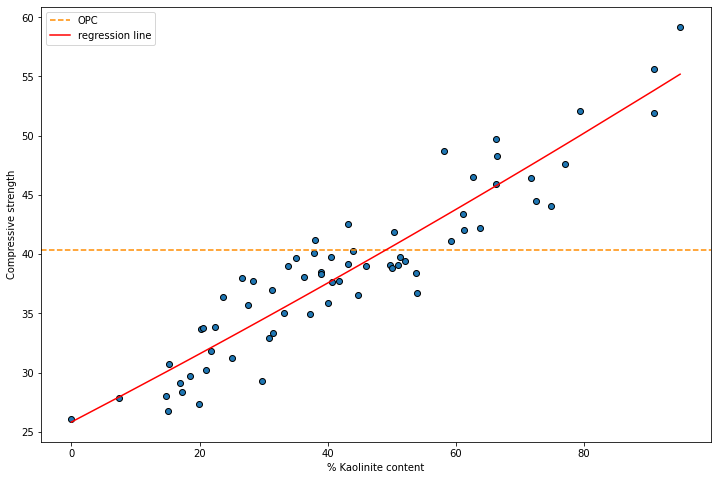

MSE: 7.226290975440005
R^2: 0.8671830793671289


In [19]:
leave_one_out_validation(x_2, y7, 7)

f(x) = 29.328626511860705 + 0.5831008578049671*x + -0.0023827865723607396*x^2


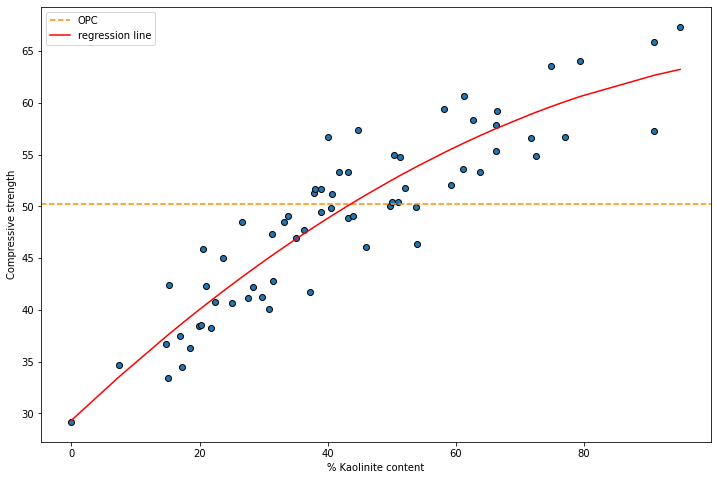

MSE: 12.724683642602644
R^2: 0.8355799295281006


In [20]:
leave_one_out_validation(x_2, y28, 28)

f(x) = 28.41098211053236 + 0.689568275382258*x + -0.0032636150266617983*x^2


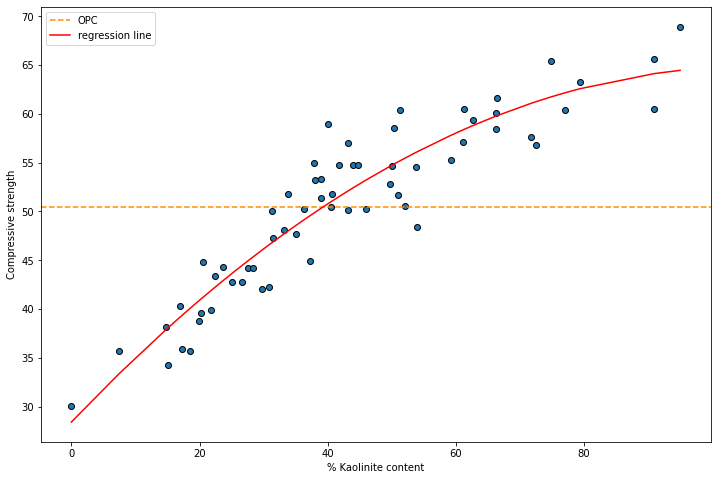

MSE: 10.517834018934327
R^2: 0.8742078730183471


In [21]:
leave_one_out_validation(x90_2, y90, 90)

**First sight analysis:**

* Expected results, better models obtained for 28th and 90th day compressive strength obtained.
* We might be experiencing overfitting with this model for 1st and 3rd day measurements because we're not increasing the compressive strength with the increase of calonita for small contents.

### Feature selection

We have seen the importance and the clear relation of the Kaolinite content with the compressive strength and, we have seen also that the models involving only kaolinite content have their limitations (because of data sparsification). For achieving better results we have to add more modelation expressiveness by adding other variables to our model (new features or other artificially created) and, since the data distribution makes us think that linear regression models with the kaolinite content in degree three or more lead to overfitting, the best choice is adding new features.

Again, for avoiding overfitting with the few data we have we can't add several features so we have to decide well which is the best feature for complementing the kaolinite content. That's the question we try to solve in this part.

In [22]:
# Which features are realiable? Those with more than RELIABLE_THRESHOLD measurements
RELIABLE_THRESHOLD = 45

features = data.columns[14:]
reliable_features = [f for f in features if data[f].describe()[0] >= RELIABLE_THRESHOLD]

Highlight maximums of R2 in color Red and minimums of MSE in color green.

In [23]:
feature_selection(data, reliable_features)

,day_1_mse,day_1_adjR2,day_3_mse,day_3_adjR2,day_7_mse,day_7_adjR2,day_28_mse,day_28_adjR2,day_90_mse,day_90_adjR2
Dv50,2.660387,0.607032,10.144909,0.756160,6.703420,0.886546,14.166799,0.819776,11.497926,0.861981
span,2.697771,0.606329,10.513250,0.748443,6.230590,0.894435,14.093763,0.823580,12.068639,0.862073
BET_specific_surface,2.741117,0.600980,10.282472,0.752225,6.499024,0.895407,14.141630,0.835419,10.279465,0.886111
SiO2,2.646833,0.549602,11.510208,0.674402,7.237414,0.864783,13.716716,0.821108,10.653247,0.867897
Al2O3,2.496351,0.559280,11.386750,0.675650,7.576186,0.853604,14.230688,0.795031,11.171484,0.845807
Fe2O3,2.451113,0.558294,11.230396,0.675651,7.546423,0.852623,13.840886,0.800208,11.099736,0.848439
CaO,1.751379,0.173835,8.579012,0.354992,7.348082,0.791633,15.241253,0.760538,12.348018,0.812905
MgO,1.778444,0.319630,9.799469,0.491711,6.281799,0.822981,14.128881,0.761032,10.135426,0.840696
Na2O,1.981754,0.401411,9.970495,0.576575,7.885464,0.839430,16.692542,0.781241,13.247514,0.829935
K2O,2.514975,0.542241,10.759655,0.666486,7.399368,0.865289,13.233865,0.827826,10.231284,0.876954


In [24]:
feature_selection(data, features)

,day_1_mse,day_1_adjR2,day_3_mse,day_3_adjR2,day_7_mse,day_7_adjR2,day_28_mse,day_28_adjR2,day_90_mse,day_90_adjR2
Dv50,2.660387,0.607032,10.144909,0.756160,6.703420,0.886546,14.166799,0.819776,11.497926,0.861981
D10,3.232965,0.711622,10.059604,0.827784,6.888915,0.917330,11.933540,0.902502,10.401052,0.913015
D90,3.175986,0.709957,10.226276,0.824700,6.328872,0.927093,11.090342,0.908331,10.933192,0.916050
span,2.697771,0.606329,10.513250,0.748443,6.230590,0.894435,14.093763,0.823580,12.068639,0.862073
BET_specific_surface,2.741117,0.600980,10.282472,0.752225,6.499024,0.895407,14.141630,0.835419,10.279465,0.886111
SiO2,2.646833,0.549602,11.510208,0.674402,7.237414,0.864783,13.716716,0.821108,10.653247,0.867897
Al2O3,2.496351,0.559280,11.386750,0.675650,7.576186,0.853604,14.230688,0.795031,11.171484,0.845807
Fe2O3,2.451113,0.558294,11.230396,0.675651,7.546423,0.852623,13.840886,0.800208,11.099736,0.848439
CaO,1.751379,0.173835,8.579012,0.354992,7.348082,0.791633,15.241253,0.760538,12.348018,0.812905
MgO,1.778444,0.319630,9.799469,0.491711,6.281799,0.822981,14.128881,0.761032,10.135426,0.840696


#### Linear regression models based on the kaolinite content and other features

Following the results obtained in the feature selection part, here we are creating and analyzing the models done with the kaolinite content (in degree one and two) as well as other features.

In [25]:
# Day 1
get_model_summary(create_r_formula(1,'Dv50'),get_model_data(data, 'Dv50','day_1'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_1   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     25.72
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           7.65e-10
Time:                        14:30:21   Log-Likelihood:                -86.895
No. Observations:                  49   AIC:                             181.8
Df Residuals:                      45   BIC:                             189.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    9.6890      0.955     10.150      0.000       7.766      11.612
Kaolinite_content           -0.0303      0.038     -0.790      0.433      -0.107       0.047
Kaolinite_content_square     0.0011      0.000      2.964      0.005       0.000       0.002
Dv50                         0.0086      0.030      0.287      0.775      -0.052       0.069
==============================================================================
Omnibus:                        3.063   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.216   Jarque-Bera (JB):                2.122
Skew:                           0.476   Prob(JB):                        0.346
Kurtosis:                       3.367   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [26]:
# Day 1
get_model_summary(create_r_formula(1,'CaO'),get_model_data(data, 'CaO','day_1'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_1   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     4.296
Date:                Thu, 17 Dec 2020   Prob (F-statistic):            0.00962
Time:                        14:30:21   Log-Likelihood:                -75.653
No. Observations:                  48   AIC:                             159.3
Df Residuals:                      44   BIC:                             166.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   10.2781      0.923     11.138      0.000       8.418      12.138
Kaolinite_content           -0.0187      0.045     -0.411      0.683      -0.110       0.073
Kaolinite_content_square     0.0006      0.001      1.140      0.260      -0.000       0.002
CaO                         -0.0600      0.102     -0.588      0.560      -0.266       0.146
==============================================================================
Omnibus:                        1.130   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.568   Jarque-Bera (JB):                0.980
Skew:                           0.118   Prob(JB):                        0.613
Kurtosis:                       2.341   Cond. No.                     1.34e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [27]:
# Day 3
get_model_summary(create_r_formula(3,'Dv50'),get_model_data(data, 'Dv50','day_3'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_3   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     50.62
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           1.82e-14
Time:                        14:30:21   Log-Likelihood:                -121.25
No. Observations:                  49   AIC:                             250.5
Df Residuals:                      45   BIC:                             258.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   20.6316      1.924     10.721      0.000      16.756      24.507
Kaolinite_content           -0.0936      0.077     -1.213      0.232      -0.249       0.062
Kaolinite_content_square     0.0033      0.001      4.287      0.000       0.002       0.005
Dv50                         0.1179      0.060      1.951      0.057      -0.004       0.240
==============================================================================
Omnibus:                        2.092   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.351   Jarque-Bera (JB):                1.858
Skew:                           0.363   Prob(JB):                        0.395
Kurtosis:                       2.381   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
# Day 3
get_model_summary(create_r_formula(3,'CaO'),get_model_data(data, 'CaO','day_3'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_3   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     9.622
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           5.30e-05
Time:                        14:30:21   Log-Likelihood:                -116.02
No. Observations:                  48   AIC:                             240.0
Df Residuals:                      44   BIC:                             247.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   21.0518      2.140      9.839      0.000      16.740      25.364
Kaolinite_content            0.0208      0.105      0.197      0.845      -0.191       0.233
Kaolinite_content_square     0.0012      0.001      0.971      0.337      -0.001       0.004
CaO                         -0.0291      0.237     -0.123      0.903      -0.506       0.448
==============================================================================
Omnibus:                        7.810   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                7.049
Skew:                           0.912   Prob(JB):                       0.0295
Kurtosis:                       3.442   Cond. No.                     1.34e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
# Day 7
get_model_summary(create_r_formula(7,'BET_specific_surface'),get_model_data(data, 'BET_specific_surface','day_7'))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_7   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     135.1
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           3.22e-22
Time:                        14:30:21   Log-Likelihood:                -108.78
No. Observations:                  48   AIC:                             225.6
Df Residuals:                      44   BIC:                             233.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   26.1528      1.323     19.766      0.000      23.486      28.819
Kaolinite_content            0.2832      0.063      4.492      0.000       0.156       0.410
Kaolinite_content_square     0.0003      0.001      0.462      0.646      -0.001       0.002
BET_specific_surface         0.0032      0.026      0.123      0.902      -0.049       0.056
==============================================================================
Omnibus:                        6.187   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                2.662
Skew:                           0.267   Prob(JB):                        0.264
Kurtosis:                       1.977   Cond. No.                     1.26e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [30]:
# Day 7
get_model_summary(create_r_formula(7,'span'),get_model_data(data, 'span','day_7'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_7   R-squared:                       0.901
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     136.6
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           1.30e-22
Time:                        14:30:21   Log-Likelihood:                -109.97
No. Observations:                  49   AIC:                             227.9
Df Residuals:                      45   BIC:                             235.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   25.7828      1.420     18.151      0.000      22.922      28.644
Kaolinite_content            0.2265      0.063      3.571      0.001       0.099       0.354
Kaolinite_content_square     0.0008      0.001      1.266      0.212      -0.000       0.002
span                         0.3019      0.130      2.314      0.025       0.039       0.565
==============================================================================
Omnibus:                        1.666   Durbin-Watson:                   2.182
Prob(Omnibus):                  0.435   Jarque-Bera (JB):                1.413
Skew:                          -0.255   Prob(JB):                        0.493
Kurtosis:                       2.342   Cond. No.                     1.41e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [31]:
# Day 28
get_model_summary(create_r_formula(28,'BET_specific_surface'),get_model_data(data, 'BET_specific_surface','day_28'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 day_28   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     80.52
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           6.71e-18
Time:                        14:30:21   Log-Likelihood:                -127.10
No. Observations:                  48   AIC:                             262.2
Df Residuals:                      44   BIC:                             269.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   29.6807      1.938     15.313      0.000      25.774      33.587
Kaolinite_content            0.6164      0.092      6.673      0.000       0.430       0.803
Kaolinite_content_square    -0.0028      0.001     -3.038      0.004      -0.005      -0.001
BET_specific_surface        -0.0190      0.038     -0.500      0.620      -0.096       0.058
==============================================================================
Omnibus:                        4.484   Durbin-Watson:                   2.332
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                1.900
Skew:                          -0.026   Prob(JB):                        0.387
Kurtosis:                       2.027   Cond. No.                     1.26e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
# Day 28
get_model_summary(create_r_formula(28,'TiO2'),get_model_data(data, 'TiO2','day_28'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 day_28   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     88.31
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           3.38e-20
Time:                        14:30:21   Log-Likelihood:                -142.30
No. Observations:                  55   AIC:                             292.6
Df Residuals:                      51   BIC:                             300.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   29.3350      2.165     13.550      0.000      24.989      33.681
Kaolinite_content            0.5267      0.091      5.799      0.000       0.344       0.709
Kaolinite_content_square    -0.0020      0.001     -2.268      0.028      -0.004      -0.000
TiO2                         1.1734      0.654      1.794      0.079      -0.140       2.487
==============================================================================
Omnibus:                        4.949   Durbin-Watson:                   2.530
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                2.079
Skew:                          -0.041   Prob(JB):                        0.354
Kurtosis:                       2.051   Cond. No.                     1.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
# Day 90
get_model_summary(create_r_formula(90,'BET_specific_surface'),get_model_data(data, 'BET_specific_surface','day_90'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 day_90   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     112.5
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           1.55e-19
Time:                        14:30:21   Log-Likelihood:                -109.43
No. Observations:                  44   AIC:                             226.9
Df Residuals:                      40   BIC:                             234.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   28.9502      1.746     16.585      0.000      25.422      32.478
Kaolinite_content            0.7102      0.085      8.392      0.000       0.539       0.881
Kaolinite_content_square    -0.0035      0.001     -4.311      0.000      -0.005      -0.002
BET_specific_surface        -0.0191      0.035     -0.552      0.584      -0.089       0.051
==============================================================================
Omnibus:                        0.608   Durbin-Watson:                   2.443
Prob(Omnibus):                  0.738   Jarque-Bera (JB):                0.720
Skew:                           0.162   Prob(JB):                        0.698
Kurtosis:                       2.463   Cond. No.                     1.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [34]:
# Day 90
get_model_summary(create_r_formula(90,'TiO2'),get_model_data(data, 'TiO2','day_90'))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 day_90   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     113.2
Date:                Thu, 17 Dec 2020   Prob (F-statistic):           1.63e-21
Time:                        14:30:21   Log-Likelihood:                -125.59
No. Observations:                  51   AIC:                             259.2
Df Residuals:                      47   BIC:                             266.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   28.0111      2.079     13.473      0.000      23.829      32.194
Kaolinite_content            0.6718      0.085      7.906      0.000       0.501       0.843
Kaolinite_content_square    -0.0032      0.001     -3.945      0.000      -0.005      -0.002
TiO2                         0.8563      0.590      1.452      0.153      -0.330       2.043
==============================================================================
Omnibus:                        0.114   Durbin-Watson:                   2.242
Prob(Omnibus):                  0.945   Jarque-Bera (JB):                0.305
Skew:                          -0.064   Prob(JB):                        0.858
Kurtosis:                       2.643   Cond. No.                     1.71e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Confidence analysis for the models

We know our model (function depending on the features provided) as well as some metrics to have an idea of how well our model fits our data (R2) and how it is behaving in practice with new data (MSE). The objective of this section is to provide a more mathematical analysis of the confidence we can expect from our models.

#### Toy examples for putting things into practice

We are going to start with the Kaolinite content based model for compression strength at day 90 to exemplify the tools and techniques we can use to estimate confidence intervals in our model.

f(x) = 10.484771154982049 + -0.055615734871761136*x + 0.001276247399357811*x^2


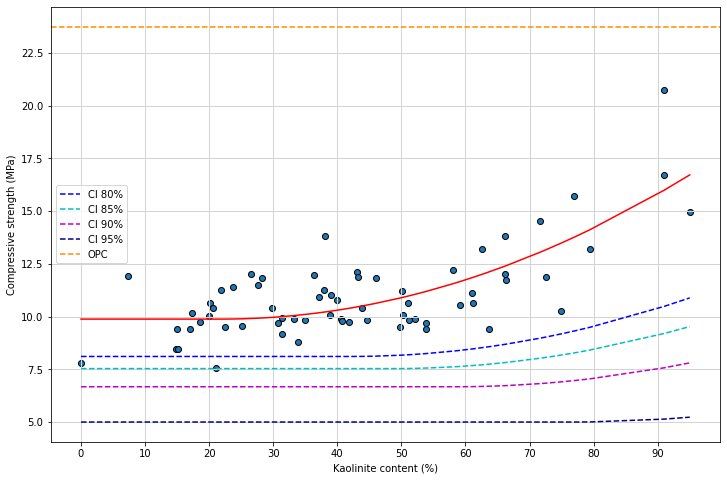

MSE: 2.5126547736924403
R^2: 0.5395335354132512



In [35]:
plot_confidence_intervals(get_model_data_kaolinite(data, 'day_1'), 1)

f(x) = 21.868297363985192 + -0.07942095616558414*x + 0.002950516766841272*x^2


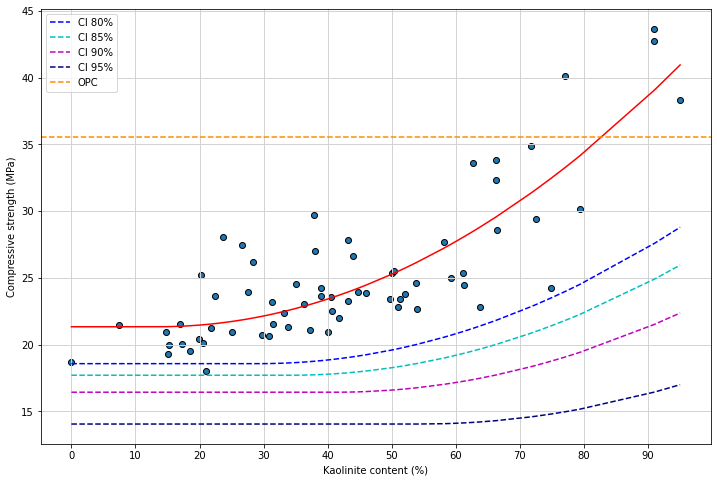

MSE: 10.154742232922898
R^2: 0.6974199940372012



In [36]:
plot_confidence_intervals(get_model_data_kaolinite(data, 'day_3'), 3)

f(x) = 25.82211635397205 + 0.2820563287364718*x + 0.00028516488888886515*x^2


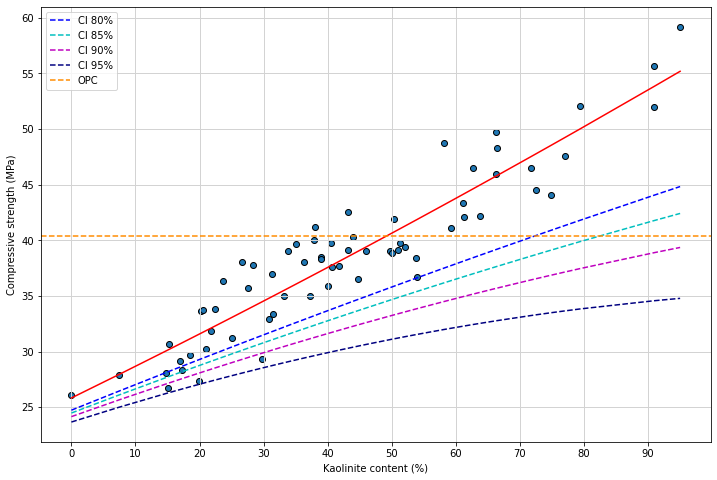

MSE: 7.226290975440005
R^2: 0.8671830793671289



In [37]:
plot_confidence_intervals(get_model_data_kaolinite(data, 'day_7'), 7)

f(x) = 29.328626511861476 + 0.5831008578049552*x + -0.0023827865723606485*x^2


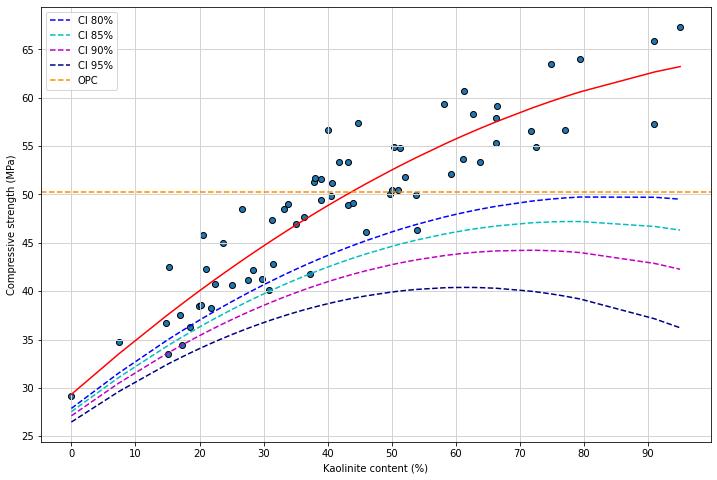

MSE: 12.724683642602644
R^2: 0.8355799295281006



In [38]:
plot_confidence_intervals(get_model_data_kaolinite(data, 'day_28'), 28)

f(x) = 28.410982110532647 + 0.6895682753822634*x + -0.003263615026661608*x^2


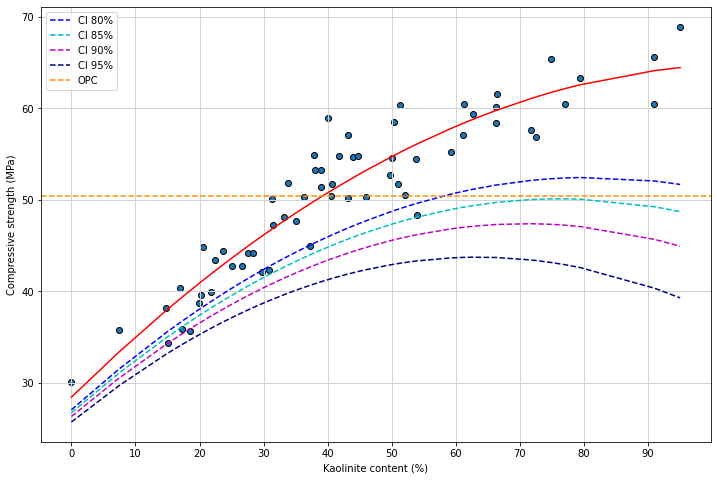

MSE: 10.517834018934327
R^2: 0.8742078730183471



In [39]:
plot_confidence_intervals(get_model_data_kaolinite(data, 'day_90'), 90)

**First sight analysis:**

* We can't afford confidence intervals of such a high precision with such a lack of points, especially for high kaolinite contents.
* However, this is worth a try after adding all the points from the second excel!

### References:

* How to deal with small datasets:\
https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89

* Feature engineering: \
https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

* Feature selection: \
https://en.wikipedia.org/wiki/Feature_selection \
https://machinelearningmastery.com/an-introduction-to-feature-selection/ \
https://machinelearningmastery.com/feature-selection-machine-learning-python/ \
https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/ \
https://machinelearningmastery.com/calculate-feature-importance-with-python/

* Linear regression with python: \
https://realpython.com/linear-regression-in-python/ 

* Confidence estimation: \
https://www.puneetarora2000.com/2020/01/data-interpretation-understanding-ols.html \
https://medium.com/@jyotiyadav99111/statistics-how-should-i-interpret-results-of-ols-3bde1ebeec01 \
https://www.statsmodels.org/stable/regression.html \
https://www.datarobot.com/blog/ordinary-least-squares-in-python/ \
https://online.stat.psu.edu/stat415/lesson/7/7.5 \
https://tungmphung.com/confidence-intervals-for-linear-regression-coefficients/ \
https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html

